# Shock Identification and Arrival Rates

Objectives:
1. Define volatility shocks using quantile thresholds.
2. Estimate homogeneous Poisson shock arrivals via inter-arrival durations.
3. Fit non-homogeneous Poisson models on monthly counts.
4. Inspect exceedances with GPD diagnostics for robustness.


In [12]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd

from src import data_pipeline, shock_modeling

vix_data = data_pipeline.prepare_series()
returns = vix_data.frame['dlog_vix'].dropna()
metadata = vix_data.metadata
metadata

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'start': Timestamp('2010-01-05 00:00:00'),
 'end': Timestamp('2025-11-24 00:00:00'),
 'rows': 4145,
 'winsor_alpha': 0.001}

In [13]:
shock_def = shock_modeling.define_shocks(returns, quantile=0.95)
shock_def.threshold
shock_def.indicator.sum()

np.int64(208)

In [14]:
interarrival = shock_modeling.interarrival_series(shock_def.indicator)
hpp = shock_modeling.fit_hpp(interarrival)
hpp

HPPResult(rate_per_day=np.float64(0.035844155844155845), rate_per_year=np.float64(9.032727272727273), ci_95=(np.float64(7.844063685337336), np.float64(10.350629046427526)))

In [15]:
monthly = shock_modeling.monthly_counts(shock_def.indicator)
nhpp = shock_modeling.fit_nhpp(monthly)
nhpp.result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 shocks   No. Observations:                  191
Model:                            GLM   Df Residuals:                      177
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -224.92
Date:                Mon, 24 Nov 2025   Deviance:                       165.22
Time:                        17:20:30   Pearson chi2:                     141.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3652
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.8840      0.286    -13.562      0.000      -4.445      -3.323
time            0.0004      0.001      0.355      0.722      -0.002       0.003
avg_log_vix     0.7912      0.090      8.748      0.000       0.614       0.968
month_2        -0.0023      0.330     -0.007      0.994      -0.648       0.643
month_3        -0.2706      0.334     -0.811      0.417      -0.924       0.383
month_4        -0.2693      0.334     -0.806      0.420      -0.924       0.386
month_5        -0.2190      0.329     -0.666      0.505      -0.864       0.426
month_6        -0.2943      0.338     -0.871      0.384      -0.956       0.368
month_7        -0.4683      0.373     -1.257      0.209      -1.199       0.262
month_8         0.1019      0.315      0.323      0.746      -0.516       0.719
month_9        -0.3328      0.357     -0.932      0.351      -1.032       0.367
month_10       -0.0554      0.320     -0.173      0.863      -0.683       0.572
month_11       -0.5123      0.395     -1.297      0.195      -1.286       0.262
month_12       -0.2191      0.356     -0.615      0.539      -0.918       0.480
===============================================================================
"""

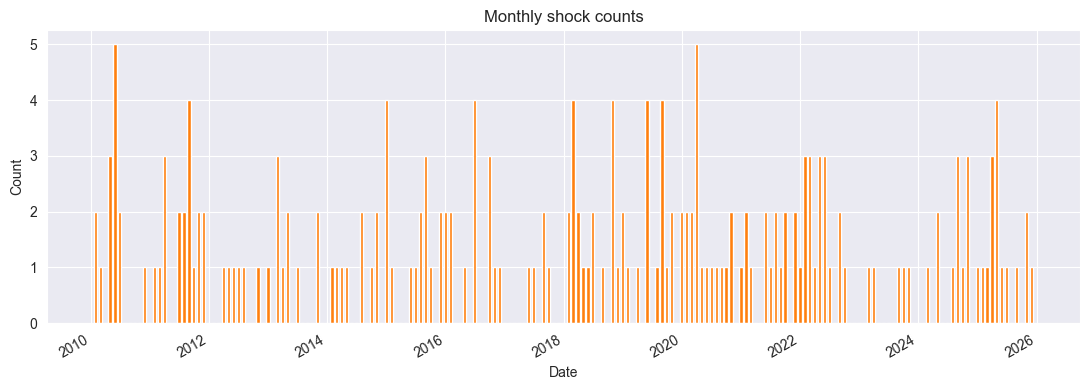

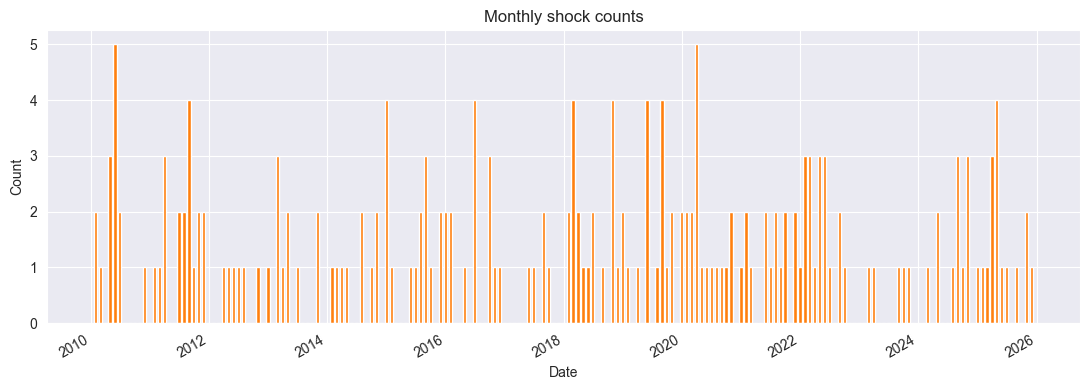

In [16]:
from src import visualization
fig = visualization.plot_shock_arrivals(monthly)
fig

## Compound Poisson Process (CPP) with Train-Test Split

We now evaluate the CPP model out-of-sample by training on 75% of the data and testing on the remaining 25%.


In [ ]:
# Fit CPP on full sample first
cpp_full = shock_modeling.fit_compound_poisson(returns, shock_def.indicator)
print(f"Full sample CPP:")
print(f"  Arrival rate: {cpp_full.arrival_rate_annual:.2f}/year")
print(f"  Jump distribution: {cpp_full.jump_distribution}")
print(f"  Mean jump E[J]: {cpp_full.mean_jump:.4f}")
print(f"  VaR 95%: {cpp_full.var_95:.3f}")
print(f"  CVaR 95%: {cpp_full.cvar_95:.3f}")


In [ ]:
# Train-test split evaluation
cpp_forecast = shock_modeling.evaluate_cpp_forecast(
    returns, 
    shock_def.indicator, 
    train_fraction=0.75,
    n_simulations=10000
)

# Print summary
summary_df = shock_modeling.cpp_forecast_summary(cpp_forecast)
print("\nCPP Out-of-Sample Evaluation:")
print("="*50)
for _, row in summary_df.iterrows():
    print(f"{row['Metric']:35s} {row['Value']}")


In [ ]:
# Visualize CPP out-of-sample evaluation
fig = visualization.plot_cpp_forecast_evaluation(
    cpp_forecast,
    returns,
    shock_def.indicator,
    n_simulations=5000,
    save_as="cpp_forecast.png"
)
fig


In [ ]:
# Optional: Rolling CPP forecast
rolling_results = shock_modeling.cpp_rolling_forecast(
    returns,
    shock_def.indicator,
    train_fraction=0.75,
    window_months=3,
    n_simulations=3000
)

print(f"\nRolling CPP Forecast ({len(rolling_results)} windows):")
print(f"  Mean shock count error: {rolling_results['shock_error'].mean()*100:.1f}%")
print(f"  Mean impact error: {rolling_results['impact_error'].mean()*100:.1f}%")

# Visualize rolling forecast
fig = visualization.plot_cpp_rolling_forecast(rolling_results, save_as=None)
fig
